In [12]:
import os
import re
import csv
import subprocess
import numpy as np
import networkx as nx
import nestedness
import matplotlib.pyplot as plt
from scipy import sparse, stats

input_path = os.path.abspath('input')
bin_path = os.path.abspath('bin')
output_path = os.path.abspath('output')
env = os.environ.copy()
env['PATH'] = '.:' + env['PATH']

# Individual nestedness contribution
## Replication of Figure 1 in [[Saavedra2011]](https://doi.org/10.1038/nature10433).

In [4]:
c = []
for filename in os.listdir(input_path):
    if (re.match('^.*\.txt$', filename, re.IGNORECASE)):
        with open(os.path.join(input_path, filename), 'rb') as adj_matrix:
            A = np.loadtxt(adj_matrix)

        network = nx.bipartite.from_biadjacency_matrix(sparse.csr_matrix(A))
        if len(network) > 205:
            continue
        print(filename)
        try:
            N = nestedness.NODF(network)
        except ValueError:
            continue
        for node in network:
            N_mean, N_std = nestedness.null_model(network, node, 1000)
            c.append((N-N_mean)/N_std)
        #np.savetxt('c.txt', c)

pollinators (1).txt
pollinators (10).txt
pollinators (11).txt
pollinators (13).txt
pollinators (14).txt
pollinators (15).txt
pollinators (16).txt
pollinators (17).txt
pollinators (18).txt
pollinators (19).txt
pollinators (2).txt
pollinators (20).txt
pollinators (21).txt
pollinators (22).txt
pollinators (23).txt
pollinators (24).txt
pollinators (25).txt
pollinators (26).txt
pollinators (27).txt
pollinators (29).txt
pollinators (3).txt
pollinators (30).txt
pollinators (31).txt
pollinators (33).txt
pollinators (34).txt
pollinators (35).txt
pollinators (4).txt
pollinators (5).txt
pollinators (6).txt
pollinators (7).txt
pollinators (8).txt
pollinators (9).txt


In [5]:
print(max(c))
print(min(c))
print(len(c))

5.666970819827743
-7.580728830950167
2863


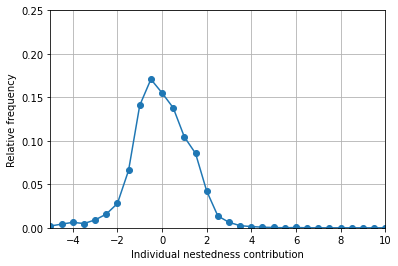

In [12]:
res = stats.relfreq(c, numbins=31, defaultreallimits=(-5, 10))
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size, res.frequency.size)
plt.plot(x, res.frequency, marker='o')
plt.xlabel('Individual nestedness contribution')
plt.ylabel('Relative frequency')
plt.xlim((x.min(), x.max()))
plt.ylim((.0, .25))
plt.grid(True)
plt.show()

## C++ implementation

In [78]:
c = []
for filename in os.listdir(input_path):
    if (re.match('^.*\.txt$', filename, re.IGNORECASE)):
        with open(os.path.join(input_path, filename), 'rb') as adj_matrix:
            A = np.loadtxt(adj_matrix)

        network = nx.bipartite.from_biadjacency_matrix(sparse.csr_matrix(A))
        if len(network) > 205:
            continue
        print(filename)
        np.savetxt(os.path.join(bin_path, 'matrix0.in.txt'), A, fmt='%d')
        subprocess.run('contributions -i 0 --contributions', cwd=bin_path, shell=True, env=env)
        with open(os.path.join(bin_path, 'matrix0.contributions.csv'), 'r', newline='') as output_file:
            csv_reader = csv.reader(output_file, delimiter=',')
            next(csv_reader)
            for row in csv_reader:
                c.append(float(row[1]))
        
        np.savetxt('c1.txt', c)

pollinators (1).txt
pollinators (10).txt
pollinators (11).txt
pollinators (13).txt
pollinators (14).txt
pollinators (15).txt
pollinators (16).txt
pollinators (17).txt
pollinators (18).txt
pollinators (19).txt
pollinators (2).txt
pollinators (20).txt
pollinators (21).txt
pollinators (22).txt
pollinators (23).txt
pollinators (24).txt
pollinators (25).txt
pollinators (26).txt
pollinators (27).txt
pollinators (29).txt
pollinators (3).txt
pollinators (30).txt
pollinators (31).txt
pollinators (33).txt
pollinators (34).txt
pollinators (35).txt
pollinators (4).txt
pollinators (5).txt
pollinators (6).txt
pollinators (7).txt
pollinators (8).txt
pollinators (9).txt


In [79]:
print(max(c))
print(min(c))
print(len(c))

5.932179038
-7.70921589
3105


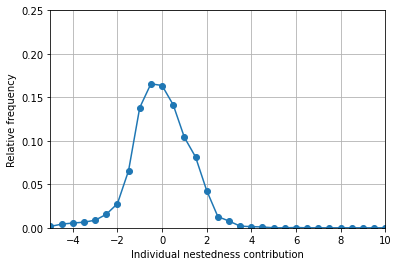

In [80]:
res = stats.relfreq(c, numbins=31, defaultreallimits=(-5, 10))
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size, res.frequency.size)
plt.plot(x, res.frequency, marker='o')
plt.xlabel('Individual nestedness contribution')
plt.ylabel('Relative frequency')
plt.xlim((x.min(), x.max()))
plt.ylim((.0, .25))
plt.grid(True)
plt.show()

# NODF calculation
## Replication of values of NODF calculated by [nullnest](https://github.com/cclaualc/nullnest) [[Payrato2019]](https://doi.org/10.1103/PhysRevX.9.031024).

In [2]:
for filename in os.listdir(input_path):
    if (re.match('^.*\.txt$', filename, re.IGNORECASE)):
        with open(os.path.join(input_path, filename), 'rb') as adj_matrix:
            A = np.loadtxt(adj_matrix)

        network = nx.bipartite.from_biadjacency_matrix(sparse.csr_matrix(A))
        try:
            N = nestedness.NODF(network)
        except ValueError:
            continue
        print(f'{filename}...', end=' ')
        sorted_rows = sorted([node for node, data in network.nodes(
            data=True) if data["bipartite"] == 0], key=network.degree, reverse=True)
        sorted_cols = sorted([node for node, data in network.nodes(
            data=True) if data["bipartite"] == 1], key=network.degree, reverse=True)
        A = nx.bipartite.biadjacency_matrix(
            network, row_order=sorted_rows, column_order=sorted_cols).toarray()

        np.savetxt(os.path.join(bin_path, 'matrix0ord.txt'), A, fmt='%d')
        np.savetxt(os.path.join(bin_path, 'matrix0rand.txt'),
                   np.ones_like(A), fmt='%f')
        np.savetxt(os.path.join(bin_path, 'general0.txt'), A.shape, fmt='%d')
        subprocess.run('NODF_analytic 0', cwd=bin_path, shell=True, env=env)

        with open(os.path.join(bin_path, 'analytic_NODF.txt'), 'r') as results:
            line = results.readline().split()
            i = line.index('NODF=')
            actual_N = float(line[i+1])

        if not np.isclose(N, actual_N):
            raise RuntimeError(f'expected {actual_N} but got {N}')
        print('pass')
try:
    os.remove(os.path.join(bin_path, 'matrix0ord.txt'))
    os.remove(os.path.join(bin_path, 'matrix0rand.txt'))
    os.remove(os.path.join(bin_path, 'general0.txt'))
    os.remove(os.path.join(bin_path, 'analytic_NODF.txt'))
except FileNotFoundError:
    pass

print('Validation completed!')

pollinators (1).txt... pass
pollinators (10).txt... pass
pollinators (11).txt... pass
pollinators (12).txt... pass
pollinators (13).txt... pass
pollinators (14).txt... pass
pollinators (15).txt... pass
pollinators (16).txt... pass
pollinators (17).txt... pass
pollinators (18).txt... pass
pollinators (19).txt... pass
pollinators (2).txt... pass
pollinators (20).txt... pass
pollinators (21).txt... pass
pollinators (22).txt... pass
pollinators (23).txt... pass
pollinators (24).txt... pass
pollinators (25).txt... pass
pollinators (26).txt... pass
pollinators (27).txt... pass
pollinators (28).txt... pass
pollinators (29).txt... pass
pollinators (3).txt... pass
pollinators (31).txt... pass
pollinators (32).txt... pass
pollinators (33).txt... pass
pollinators (34).txt... pass
pollinators (4).txt... pass
pollinators (5).txt... pass
pollinators (6).txt... pass
pollinators (7).txt... pass
pollinators (8).txt... pass
pollinators (9).txt... pass
Validation completed!


## C++ implementation

In [76]:
for filename in os.listdir(input_path):
    if (re.match('^.*\.txt$', filename, re.IGNORECASE)):
        with open(os.path.join(input_path, filename), 'rb') as adj_matrix:
            A = np.loadtxt(adj_matrix)

        network = nx.bipartite.from_biadjacency_matrix(sparse.csr_matrix(A))

        zero_degree_nodes = [node for node in network if network.degree(node) == 0]
        network.remove_nodes_from(zero_degree_nodes)
        print(f'{filename}...', end=' ')
        sorted_rows = sorted([node for node, data in network.nodes(
            data=True) if data["bipartite"] == 0], key=network.degree, reverse=True)
        sorted_cols = sorted([node for node, data in network.nodes(
            data=True) if data["bipartite"] == 1], key=network.degree, reverse=True)
        A = nx.bipartite.biadjacency_matrix(
            network, row_order=sorted_rows, column_order=sorted_cols).toarray()

        np.savetxt(os.path.join(bin_path, 'matrix0ord.txt'), A, fmt='%d')
        np.savetxt(os.path.join(bin_path, 'matrix0.in.txt'), A, fmt='%d')
        np.savetxt(os.path.join(bin_path, 'matrix0rand.txt'),
                   np.ones_like(A), fmt='%f')
        np.savetxt(os.path.join(bin_path, 'general0.txt'), A.shape, fmt='%d')
        subprocess.run('NODF_analytic 0', cwd=bin_path, shell=True, env=env)
        subprocess.run('contributions -i 0 --nodf', cwd=bin_path, shell=True, env=env)

        with open(os.path.join(bin_path, 'analytic_NODF.txt'), 'r') as results:
            line = results.readline().split()
            i = line.index('NODF=')
            actual_N = float(line[i+1])
        with open(os.path.join(bin_path, 'matrix0.nodf.txt'), 'r') as results:
            line = results.readline()
            N = float(line)

        if not np.isclose(N, actual_N):
            raise RuntimeError(f'expected {actual_N} but got {N}')
        print('pass')
try:
    os.remove(os.path.join(bin_path, 'matrix0ord.txt'))
    os.remove(os.path.join(bin_path, 'matrix0rand.txt'))
    os.remove(os.path.join(bin_path, 'general0.txt'))
    os.remove(os.path.join(bin_path, 'analytic_NODF.txt'))
    os.remove(os.path.join(bin_path, 'matrix0.in.txt'))
    os.remove(os.path.join(bin_path, 'matrix0.nodf.txt'))
except FileNotFoundError:
    pass

print('Validation completed!')

pollinators (1).txt... pass
pollinators (10).txt... pass
pollinators (11).txt... pass
pollinators (12).txt... pass
pollinators (13).txt... pass
pollinators (14).txt... pass
pollinators (15).txt... pass
pollinators (16).txt... pass
pollinators (17).txt... pass
pollinators (18).txt... pass
pollinators (19).txt... pass
pollinators (2).txt... pass
pollinators (20).txt... pass
pollinators (21).txt... pass
pollinators (22).txt... pass
pollinators (23).txt... pass
pollinators (24).txt... pass
pollinators (25).txt... pass
pollinators (26).txt... pass
pollinators (27).txt... pass
pollinators (28).txt... pass
pollinators (29).txt... pass
pollinators (3).txt... pass
pollinators (30).txt... pass
pollinators (31).txt... pass
pollinators (32).txt... pass
pollinators (33).txt... pass
pollinators (34).txt... pass
pollinators (35).txt... pass
pollinators (4).txt... pass
pollinators (5).txt... pass
pollinators (6).txt... pass
pollinators (7).txt... pass
pollinators (8).txt... pass
pollinators (9).txt...

# Speedup

In [69]:
filename = 'pollinators (33).txt'
with open(os.path.join(input_path, filename), 'rb') as adj_matrix:
    A = np.loadtxt(adj_matrix)

network = nx.bipartite.from_biadjacency_matrix(sparse.csr_matrix(A))
zero_degree_nodes = [node for node in network if network.degree(node) == 0]
network.remove_nodes_from(zero_degree_nodes)
sorted_rows = sorted([node for node, data in network.nodes(data=True) if data["bipartite"] == 0], key=network.degree, reverse=True)
sorted_cols = sorted([node for node, data in network.nodes(data=True) if data["bipartite"] == 1], key=network.degree, reverse=True)
A = nx.bipartite.biadjacency_matrix(network, row_order=sorted_rows, column_order=sorted_cols).toarray()
np.savetxt(os.path.join(bin_path, 'matrix0.in.txt'), A, fmt='%d')
print(f'{filename}')

pollinators (33).txt


In [70]:
%%timeit -o
subprocess.run('contributions -i 0 --contributions', cwd=bin_path, shell=True, env=env)

123 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 123 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [71]:
cpp_time = _.average

In [72]:
%%timeit -o
c = []
N = nestedness.NODF(network)
for node in network:
    N_mean, N_std = nestedness.null_model(network, node, 1000)
    c.append((N-N_mean)/N_std)

1min 14s ± 298 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 14s ± 298 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [73]:
py_time = _.average

In [74]:
print('Speedup: ', py_time/cpp_time)

Speedup:  604.3226870368269


In [75]:
try:
    os.remove(os.path.join(bin_path, 'matrix0.in.txt'))
    os.remove(os.path.join(bin_path, 'matrix0.contributions.csv'))
except FileNotFoundError:
    pass